###
Nama    : Rikardo Harefa
###
Nim     : 4222201056
###
Prodi   : Robotika Pagi - B
###


## **Dataset Preparation**


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from mlxtend.data import loadlocal_mnist
import pandas as pd
import random

In [19]:
raw_train_images, raw_train_labels = loadlocal_mnist(
    images_path=r'C:\Users\R\Documents\KULIAH\SEMESTER 6\RE604 COMPUTER VISION\UTS-CV\UTS COMPUTER VISION\emnist-letters-test-images-idx3-ubyte',
    labels_path=r'C:\Users\R\Documents\KULIAH\SEMESTER 6\RE604 COMPUTER VISION\UTS-CV\UTS COMPUTER VISION\emnist-letters-test-labels-idx1-ubyte'
)

In [20]:

raw_test_images, raw_train_labels = loadlocal_mnist(
    images_path=r'C:\Users\R\Documents\KULIAH\SEMESTER 6\RE604 COMPUTER VISION\UTS-CV\UTS COMPUTER VISION\emnist-letters-test-images-idx3-ubyte',
    labels_path=r'C:\Users\R\Documents\KULIAH\SEMESTER 6\RE604 COMPUTER VISION\UTS-CV\UTS COMPUTER VISION\emnist-letters-test-labels-idx1-ubyte'
)



In [7]:
train_images = []
train_labels = []

np.random.seed(42)

for i in range(1, 27):
    indices = np.where(raw_train_labels == i)[0]
    if len(indices) >= 100:
        selected_indices = np.random.choice(indices, size=100, replace=False)
        train_images.append(raw_train_images[selected_indices])
        train_labels.append(raw_train_labels[selected_indices])
    else:
        print(f"Skipping class {i}: only {len(indices)} samples found.")

train_images = np.vstack(train_images)
train_labels = np.hstack(train_labels)

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)

Train images shape: (2600, 784)
Train labels shape: (2600,)


Text(0.5, 1.0, 'Label: A')

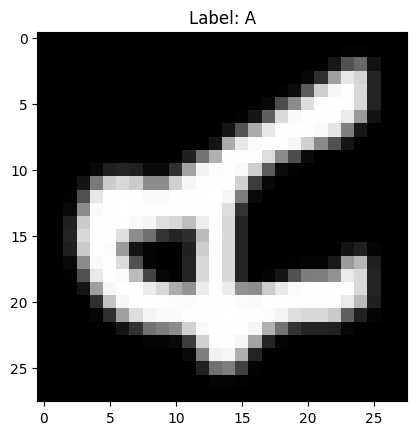

In [21]:
plt.imshow(train_images[1].reshape(28,28), cmap='gray')
plt.title(f"Label: {chr(train_labels[1] + 64)}")

In [22]:
flattened = train_images.reshape(train_images.shape[0], -1)
df = pd.DataFrame(flattened)
df['label'] = train_labels

In [23]:
shuffled_indices = np.random.permutation(len(df))
df = df.iloc[shuffled_indices].reset_index(drop=True)

In [24]:
X = df.drop('label', axis=1).values
y = df['label'].values

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Train set size: (2080, 784)
Test set size: (520, 784)


C:\Users\R\AppData\Local\Temp\ipykernel_8296\3028828459.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Blues")


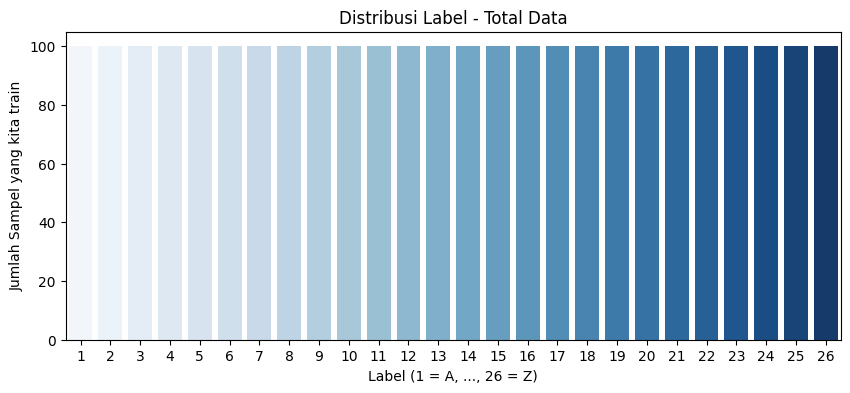

In [26]:
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.countplot(x=y, palette="Blues")
plt.title("Distribusi Label - Total Data")
plt.xlabel("Label (1 = A, ..., 26 = Z)")
plt.ylabel("Jumlah Sampel yang kita train")
plt.show()

## **Feature Extraction**

In [27]:
from skimage.feature import hog

def extract_hog_features(images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    hog_features = []
    for img in images:
        img_reshaped = img.reshape((28, 28))
        features = hog(img_reshaped,
                       orientations=12,
                       pixels_per_cell=(6,6),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

In [16]:
orientations = 12
pixels_per_cell = (4, 4)
cells_per_block = (2, 2)

In [29]:
X_train_hog = extract_hog_features(X_train, orientations, pixels_per_cell, cells_per_block)
X_test_hog = extract_hog_features(X_test, orientations, pixels_per_cell, cells_per_block)

print("HOG Feature Shape (Train):", X_train_hog.shape)
print("HOG Feature Shape (Test):", X_test_hog.shape)

HOG Feature Shape (Train): (2080, 432)
HOG Feature Shape (Test): (520, 432)


## **Classification**

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

In [31]:
svc = SVC()

grid_search = GridSearchCV(svc, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_hog, y_train)

print("Best Parameters from Grid Search:")
print(grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters from Grid Search:
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [32]:
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_hog)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.85      0.71        20
           2       0.73      0.80      0.76        20
           3       0.74      0.85      0.79        20
           4       0.94      0.80      0.86        20
           5       0.94      0.85      0.89        20
           6       0.95      0.95      0.95        20
           7       0.62      0.50      0.56        20
           8       0.78      0.70      0.74        20
           9       0.61      0.55      0.58        20
          10       0.78      0.90      0.84        20
          11       0.84      0.80      0.82        20
          12       0.67      0.70      0.68        20
          13       0.87      1.00      0.93        20
          14       0.72      0.65      0.68        20
          15       0.86      0.90      0.88        20
          16       0.82      0.90      0.86        20
          17       0.72      0.65      0.68        20
   

## **Evaluation**


In [33]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

y_train_pred = best_svm.predict(X_train_hog)
print("=== Evaluation on TRAINING Set ===")
print("Accuracy  :", accuracy_score(y_train, y_train_pred))
print("Precision :", precision_score(y_train, y_train_pred, average='macro'))
print("Recall    :", recall_score(y_train, y_train_pred, average='macro'))
print("F1-score  :", f1_score(y_train, y_train_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

=== Evaluation on TRAINING Set ===
Accuracy  : 1.0
Precision : 1.0
Recall    : 1.0
F1-score  : 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00        80
           5       1.00      1.00      1.00        80
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00        80
           8       1.00      1.00      1.00        80
           9       1.00      1.00      1.00        80
          10       1.00      1.00      1.00        80
          11       1.00      1.00      1.00        80
          12       1.00      1.00      1.00        80
          13       1.00      1.00      1.00        80
          14       1.00      1.00      1.00        80
          15       1.00      1.00      1.00        80
          1

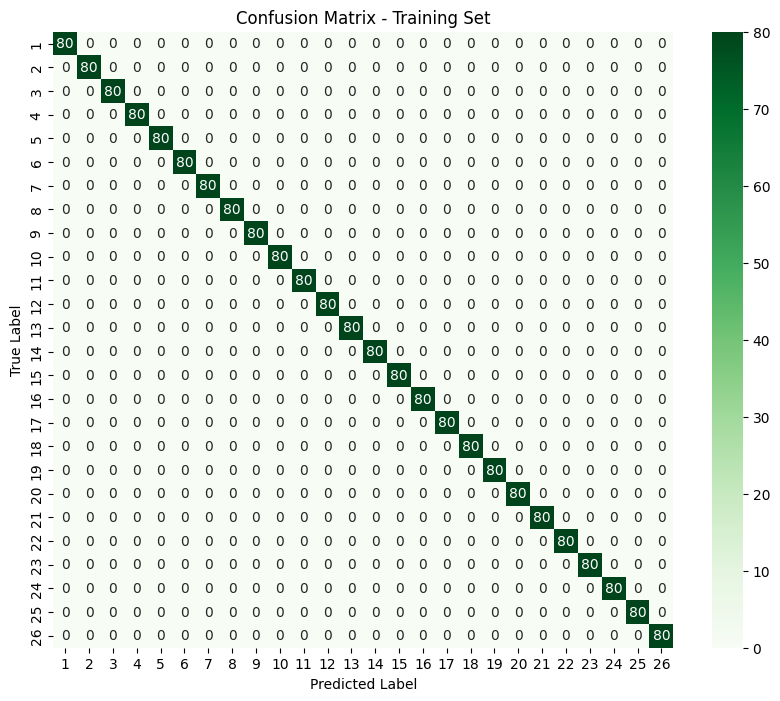

In [34]:
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=range(1, 27), yticklabels=range(1, 27))
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [35]:
y_test_pred = best_svm.predict(X_test_hog)
print("\n=== Evaluation on TESTING Set ===")
print("Accuracy  :", accuracy_score(y_test, y_test_pred))
print("Precision :", precision_score(y_test, y_test_pred, average='macro'))
print("Recall    :", recall_score(y_test, y_test_pred, average='macro'))
print("F1-score  :", f1_score(y_test, y_test_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


=== Evaluation on TESTING Set ===
Accuracy  : 0.8115384615384615
Precision : 0.8157228734308422
Recall    : 0.8115384615384614
F1-score  : 0.8100787654113308

Classification Report:
               precision    recall  f1-score   support

           1       0.61      0.85      0.71        20
           2       0.73      0.80      0.76        20
           3       0.74      0.85      0.79        20
           4       0.94      0.80      0.86        20
           5       0.94      0.85      0.89        20
           6       0.95      0.95      0.95        20
           7       0.62      0.50      0.56        20
           8       0.78      0.70      0.74        20
           9       0.61      0.55      0.58        20
          10       0.78      0.90      0.84        20
          11       0.84      0.80      0.82        20
          12       0.67      0.70      0.68        20
          13       0.87      1.00      0.93        20
          14       0.72      0.65      0.68        20
     

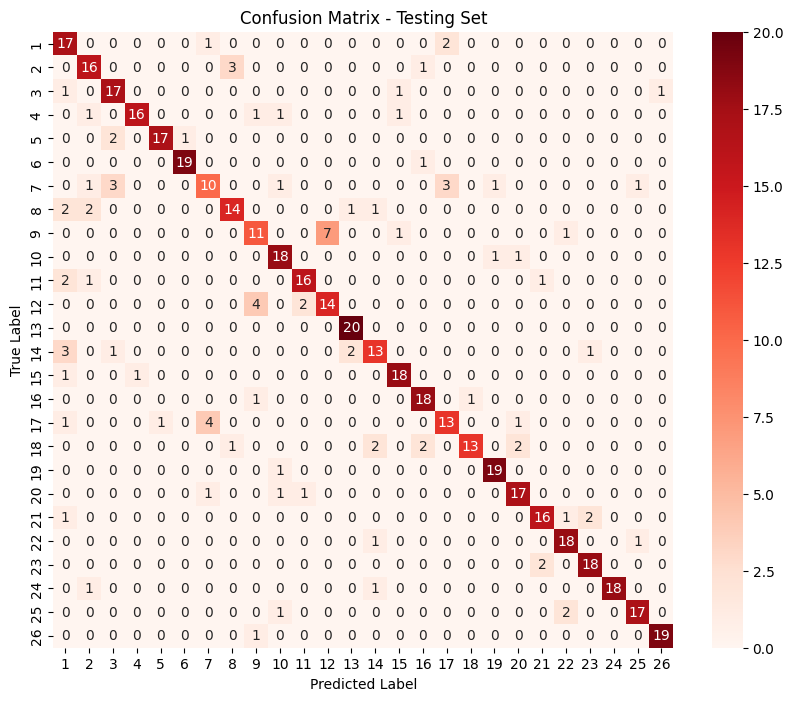

In [36]:
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', xticklabels=range(1, 27), yticklabels=range(1, 27))
plt.title("Confusion Matrix - Testing Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## **Testing Model**

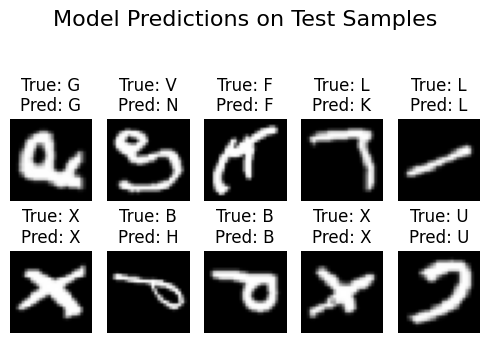

In [37]:
import random

num_samples = 10
random_indices = random.sample(range(len(X_test_hog)), num_samples)

plt.figure(figsize=(5, 5))
for i, idx in enumerate(random_indices):
    image = X_test[idx].reshape(28, 28)
    true_label = y_test[idx]
    pred_label = y_test_pred[idx]

    plt.subplot(3, 5, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {chr(true_label + 64)}\nPred: {chr(pred_label + 64)}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Model Predictions on Test Samples", fontsize=16)
plt.subplots_adjust(top=0.8)
plt.show()